# Final 4: Models Notebook
Julian Himes  
March 2017

In [47]:
# imports

import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import classification_report

plt.style.use('ggplot')

%matplotlib inline

In [2]:
# load data

loans = pd.read_csv('../assets/loan.csv', low_memory=False)

In [3]:
# add new variables

pd.options.mode.chained_assignment = None

loans['is_late'] = 0
loans['amount'] = loans.loan_amnt / 1000
loans['income'] = loans.annual_inc / 1000
loans['intercept'] = 1.0

In [4]:
# define outcome variable is_late

def is_late(text_in):
    try:
        if ('Default' in str(text_in))\
        or ('Charged Off' in str(text_in))\
        or ('Late (16-30 days)' in str(text_in))\
        or ('Late (31-120 days)' in str(text_in))\
        or ('Does not meet the credit policy. Status:Charged Off'\
        in str(text_in)):
            return 1
        else:
            return 0
    except: 
        return 0

loans['is_late'] = loans['loan_status'].map(is_late)

In [5]:
# fill missing values with means

amount_mean = loans.amount.mean()
income_mean = loans.income.mean()

loans.amount = loans.amount.fillna(amount_mean)
loans.income = loans.income.fillna(income_mean)

In [6]:
# create dummies for loan type ('purpose')

loans = pd.get_dummies(loans, columns=['purpose'], drop_first=True)

In [7]:
# create new dataframe with only desired columns

df = loans[['is_late', 'income', 'amount', 'purpose_credit_card',
        'purpose_small_business', 'purpose_other', 'purpose_wedding',
        'purpose_debt_consolidation', 'purpose_home_improvement',
        'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
        'purpose_vacation', 'purpose_house', 'purpose_renewable_energy',
        'purpose_educational', 'intercept']]

In [8]:
# set up training columns

train_cols = ['income', 'amount', 'purpose_credit_card',
            'purpose_small_business', 'purpose_other',
            'purpose_wedding', 'purpose_debt_consolidation',
            'purpose_home_improvement', 'purpose_major_purchase',
            'purpose_medical', 'purpose_moving', 'purpose_vacation',
            'purpose_house', 'purpose_renewable_energy',
            'purpose_educational', 'intercept']

In [9]:
# sklearn train test split

X = df[train_cols]
y = df['is_late']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [17]:
# run logit model

logit = sm.Logit(y_train, X_train)
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.246893
         Iterations 7


In [18]:
# check odds ratios

lparams = np.exp(result.params)
lconf = np.exp(result.conf_int())
lconf['Odds Ratio'] = lparams
lconf.columns = ['2.5%', '97.5%', 'Odds Ratio']
lconf.sort_values(by='Odds Ratio', ascending=False, inplace=True)
print lconf

                                2.5%     97.5%  Odds Ratio
purpose_educational         2.972694  5.442603    4.022337
purpose_small_business      2.659911  3.409892    3.011645
purpose_wedding             1.758789  2.543291    2.114974
purpose_moving              1.519260  2.055091    1.766980
purpose_house               1.434005  2.006227    1.696154
purpose_other               1.347911  1.690518    1.509526
purpose_medical             1.292286  1.710661    1.486830
purpose_renewable_energy    0.996729  2.124706    1.455251
purpose_vacation            1.072621  1.509852    1.272596
purpose_major_purchase      0.976301  1.262495    1.110214
purpose_debt_consolidation  0.983350  1.217750    1.094292
purpose_home_improvement    0.925972  1.164863    1.038571
amount                      1.017216  1.020135    1.018674
income                      0.992274  0.992950    0.992612
purpose_credit_card         0.697842  0.867399    0.778015
intercept                   0.079570  0.098601    0.0885

In [12]:
# fit another logit

lm = LogisticRegression()
lm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
# check score

feature_set = df[train_cols]
print lm.score(feature_set, df['is_late'])

0.931059896617


In [15]:
# nice score but consider base rate

base_rate = 1.0 * df.is_late[df.is_late == 1].count() / len(df)
on_time = 1 - base_rate
logit_score = lm.score(feature_set, df['is_late'])

print "Base rate of late payments: %r" % base_rate
print "Rate of on-time payments: %r" % on_time
print "Logit score (mean accuracy) %r" % logit_score

Base rate of late payments: 0.06894010338310913
Rate of on-time payments: 0.9310598966168908
Logit score (mean accuracy) 0.93105989661689081


In [29]:
# cross validation

feature_set = X_train
gs = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)],
                'class_weight': [None, 'balanced']},
    cv=KFold(n_splits=10),
    scoring='roc_auc'
)

# fit this on x train, y train
gs.fit(feature_set, y_train)
gs.cv_results_

{'mean_fit_time': array([ 1.94485791,  2.47536924,  1.97952051,  2.39187565,  1.94897141,
         2.40238039,  1.94223237,  2.37961719,  1.94746792,  2.4215656 ,
         1.92787542,  2.40665538,  1.92329609,  2.36073723,  1.91605098,
         1.95815253,  1.69282246,  1.68487914,  1.65045822,  1.44683223]),
 'mean_score_time': array([ 0.0234282 ,  0.02372935,  0.02325518,  0.0235044 ,  0.02377858,
         0.02387519,  0.02334323,  0.02387028,  0.0231262 ,  0.0243876 ,
         0.02340629,  0.02367949,  0.02300763,  0.02382438,  0.023227  ,
         0.02359619,  0.02355294,  0.02401779,  0.02828438,  0.02517729]),
 'mean_test_score': array([ 0.59604471,  0.59548917,  0.59601916,  0.59548271,  0.59604474,
         0.59548997,  0.5960449 ,  0.59548672,  0.59604741,  0.59548725,
         0.59609722,  0.59549439,  0.59627365,  0.59553306,  0.59615531,
         0.59539871,  0.59589734,  0.59518336,  0.57213103,  0.59375997]),
 'mean_train_score': array([ 0.59642268,  0.59582313,  0.596465

In [30]:
# check best parameters

print gs.best_params_

{'C': 0.1, 'class_weight': None}


In [34]:
# show precision and recall

y_true, y_pred = y_test, gs.predict(X_test)
print classification_report(y_true, y_pred)

             precision    recall  f1-score   support

          0       0.93      1.00      0.96    272535
          1       0.00      0.00      0.00     20301

avg / total       0.87      0.93      0.90    292836

             precision    recall  f1-score   support

          0       0.93      1.00      0.96    272535
          1       0.00      0.00      0.00     20301

avg / total       0.87      0.93      0.90    292836



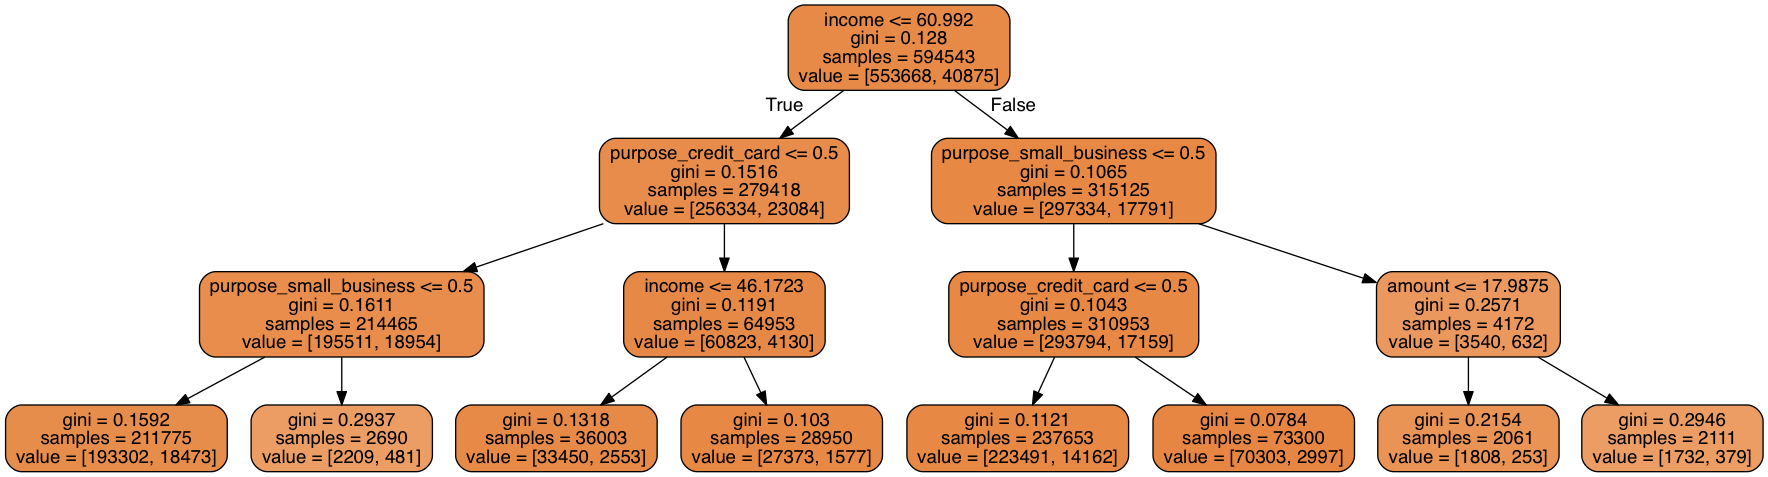

In [42]:
# try a decision tree

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
import pydot 
from os import system
from IPython.display import Image

model = DecisionTreeClassifier(max_depth=3)

model.fit(X_train, y_train)


def show_tree(model):
    dot_data = StringIO()
    export_graphviz(model, 
                    out_file = dot_data, 
                    feature_names = X.columns, 
                    filled=True, 
                    rounded=True)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return Image(graph[0].create_png())
    
show_tree(model)

In [48]:
# cross val for optimum depth

for depth in range(2, 10):
    model = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc',
                             cv=5)
    print(depth, scores.mean())

(2, 0.56462412874635981)
(3, 0.57389952011478784)
(4, 0.58283668009931611)
(5, 0.59178185039558451)
(6, 0.59344619392570619)
(7, 0.59419887737339638)
(8, 0.59476683153453647)
(9, 0.59380735594516121)


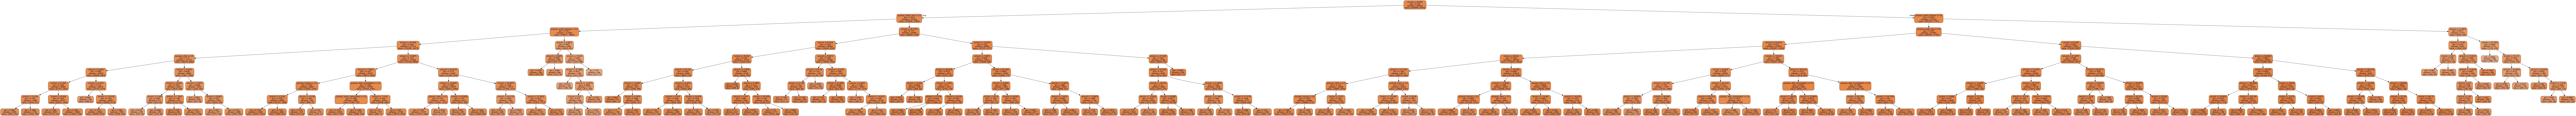

In [56]:
# seems to peak at depth 8 - run model w/ this depth and set min samples

model = DecisionTreeClassifier(max_depth=8, min_samples_leaf=250)
model.fit(X_train, y_train)

show_tree(model)

In [50]:
# predict probabilities of is_late for test set

model.predict_proba(X_test)

array([[ 0.9434076 ,  0.0565924 ],
       [ 0.94402187,  0.05597813],
       [ 0.93622364,  0.06377636],
       ..., 
       [ 0.92211251,  0.07788749],
       [ 0.95485484,  0.04514516],
       [ 0.92211251,  0.07788749]])

In [51]:
# return score for decision tree model

model.score(X_test, y_test)

0.9305925500962996

In [57]:
# try a random forest

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [58]:
# check feature importance

features = X_train.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

Features  Importance Score
0                      income          0.518511
1                      amount          0.468106
3      purpose_small_business          0.003641
2         purpose_credit_card          0.002752
6  purpose_debt_consolidation          0.000902

CV AUC [ 0.53636402  0.54044202  0.5412478 ], Average AUC 0.539351279437
n trees: 1, CV AUC [ 0.51033509  0.51135128  0.51041391], Average AUC 0.510700093714
n trees: 11, CV AUC [ 0.53576886  0.53682561  0.53802208], Average AUC 0.536872185318
n trees: 21, CV AUC [ 0.5392037   0.53978834  0.54162317], Average AUC 0.54020506894
n trees: 31, CV AUC [ 0.53848209  0.53892907  0.54259172], Average AUC 0.540000958677
n trees: 41, CV AUC [ 0.53939627  0.54077731  0.54208368], Average AUC 0.540752421167
n trees: 51, CV AUC [ 0.54009042  0.54314051  0.54394249], Average AUC 0.54239113865
n trees: 61, CV AUC [ 0.53990085  0.54257306  0.54372046], Average AUC 0.542064791121
n trees: 71, CV AUC [ 0.53986949  0.5432455   0.54483263], Average AUC 0.542649207126
n trees: 81, CV AUC [ 0.5403056   0.54207996  0.54457559], Average AUC 0.542320382572
n trees: 91, CV AUC [ 0.54137498  0.54226513  0.54466271], Average AUC 0.542767608158


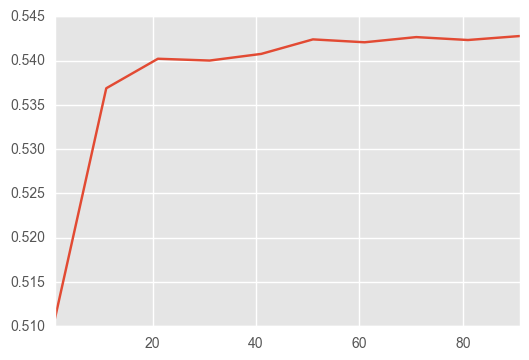

In [59]:
# cross val for optimum number of trees

scores = cross_val_score(model, X_train, y_train, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

auc_scores = {}
for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc')
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))
    auc_scores[n_trees] = scores.mean()
pd.Series(auc_scores, name='AUC Scores').plot();

In [62]:
# diminishing returns after 50 trees

model = RandomForestClassifier(n_estimators = 50, max_depth=8,
                               min_samples_leaf=250)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=250,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [63]:
# score model on test set

model.score(X_test, y_test)

0.93067450723271727